In [1]:
# Code functionality: Adaptive mixer allocation strategy
# Step 1: 1-layer ansatz, mixers applied to some vertices
# Step 2: Select some operators from the operator pool and add them to the current circuit. The selection criterion: a score composed of the average gradient and average expectation function value. Only mixers are added.
# Step 3: Optimize the current circuit
# Step 4: Repeat Step 2 and Step 3 until the iteration convergence condition is met

In [2]:
from mindquantum.core.circuit import Circuit, UN
from mindquantum.core.gates import H, ZZ, RX,RZ,X,I,Measure
from mindquantum.core.operators import Hamiltonian, QubitOperator
from mindquantum.framework import MQAnsatzOnlyLayer,MQLayer,MQAnsatzOnlyOps
from mindquantum.simulator import Simulator
from mindspore.common.initializer import Normal,initializer
from mindspore import Tensor,ops
from mindspore import dtype as mstype
from mindspore.common.parameter import Parameter
from mindspore.nn import Adam, TrainOneStepCell                   

import networkx as nx
import mindspore.nn as nn
import mindspore as ms
import mindquantum as mq
import copy
from math import pi


import matplotlib.pyplot as plt
import numpy as np
from math import pi
from mpl_toolkits.mplot3d import Axes3D



# 加载额外需要用到的包
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import random
import time


import warnings
warnings.filterwarnings("ignore")


import logging
import sys
import datetime
 
def init_logger(filename, logger_name):
    '''
    @brief:
        initialize logger that redirect info to a file just in case we lost connection to the notebook
    @params:
        filename: to which file should we log all the info
        logger_name: an alias to the logger
    '''
 
    # get current timestamp
    timestamp = datetime.datetime.utcnow().strftime('%Y%m%d_%H-%M-%S')
    
    logging.basicConfig(
        level=logging.INFO, 
        format='%(message)s',
#         format='%(message)s',
        handlers=[
            logging.FileHandler(filename=filename,encoding='utf-8'),
            logging.StreamHandler(sys.stdout)
        ]
    )
 
    # Test
    logger = logging.getLogger(logger_name)
   #logger.info('### Init. Logger {} ###'.format(logger_name))
    return logger


# Initialize
my_logger = init_logger("test.log", "ml_logger")

In [3]:
# Compute the circuit depth using this interface

# right 2021 Huawei Technologies Co., Ltd
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ============================================================================
"""DAG Circuit."""
import typing

from mindquantum.core import Circuit, gates
from mindquantum.utils.type_value_check import _check_input_type

# pylint: disable=invalid-name


class DAGNode:
    """
    Basic node in Directed Acyclic Graph.

    A DAG node has local index, which label the index of leg of node, and child nodes and father nodes.
    """

    def __init__(self):
        """Initialize a DAGNode object."""
        self.child: typing.Dict[int, "DAGNode"] = {}  # key: local index, value: child DAGNode
        self.father: typing.Dict[int, "DAGNode"] = {}  # key: local index, value: father DAGNode
        self.local: typing.List[int] = []

    def clean(self):
        """Clean node and set it to empty."""
        self.child = {}
        self.father = {}
        self.local = []

    def insert_after(self, other_node: "DAGNode"):
        """
        Insert other node after this dag node.

        Args:
            other_node (:class:`~.algorithm.compiler.DAGNode`): other DAG node.
        """
        _check_input_type("other_node", DAGNode, other_node)
        for local in self.local:
            if local in other_node.local:
                other_node.father[local] = self
                if local in self.child:
                    other_node.child[local] = self.child.get(local)
                    self.child.get(local).fathre[local] = other_node
                self.child[local] = other_node

    def insert_before(self, other_node: "DAGNode"):
        """
        Insert other node before this dag node.

        Args:
            other_node (:class:`~.algorithm.compiler.DAGNode`): other DAG node.
        """
        _check_input_type("other_node", DAGNode, other_node)
        for local in self.local:
            if local in other_node.local:
                other_node.child[local] = self
                if local in self.father:
                    other_node.father[local] = self.father.get(local)
                    self.father.get(local).child[local] = other_node
                self.father[local] = other_node


def connect_two_node(father_node: DAGNode, child_node: DAGNode, local_index: int):
    """
    Connect two DAG node through given local_index.

    Args:
        father_node (DAGNode): The father DAG node.
        child_node (DAGNode): The child DAG node.
        local_index (int): which leg you want to connect.
    """
    if local_index not in father_node.local or local_index not in child_node.local:
        raise ValueError(
            f"local_index {local_index} not in father_node" f" {father_node} or not in child_node {child_node}."
        )
    father_node.child[local_index] = child_node
    child_node.father[local_index] = father_node


class DAGQubitNode(DAGNode):
    """
    DAG node that work as quantum qubit.

    Args:
        qubit (int): id of qubit.
    """

    def __init__(self, qubit: int):
        """Initialize a DAGQubitNode object."""
        super().__init__()
        _check_input_type("qubit", int, qubit)
        self.qubit = qubit
        self.local = [qubit]

    def __str__(self):
        """Return a string representation of qubit node."""
        return f"q{self.qubit}"

    def __repr__(self):
        """Return a string representation of qubit node."""
        return self.__str__()


class GateNode(DAGNode):
    """
    DAG node that work as quantum gate.

    Args:
        gate (:class:`~.core.gates.BasicGate`): Quantum gate.
    """

    def __init__(self, gate: gates.BasicGate):
        """Initialize a GateNode object."""
        super().__init__()
        _check_input_type("gate", gates.BasicGate, gate)
        self.gate = gate
        self.local = gate.obj_qubits + gate.ctrl_qubits

    def __str__(self):
        """Return a string representation of gate node."""
        return str(self.gate)

    def __repr__(self):
        """Return a string representation of gate node."""
        return self.__str__()


class BarrierNode(GateNode):
    """DAG node that work as barrier."""

    def __init__(self, gate: gates.BasicGate, all_qubits: typing.List[int]):
        """Initialize a BarrierNode object."""
        super().__init__(gate)
        self.local = all_qubits


class DAGCircuit:
    """
    A Directed Acyclic Graph of a quantum circuit.

    Args:
        circuit (:class:`~.core.circuit.Circuit`): the input quantum circuit.

    Examples:
    from mindquantum.algorithm.compiler import DAGCircuit
    from mindquantum.core.circuit import Circuit
    circ = Circuit().h(0).x(1, 0)
    dag_circ = DAGCircuit(circ)
    dag_circ.head_node[0]
        q0
    dag_circ.head_node[0].child
        {0: H(0)}
    """

    def __init__(self, circuit: Circuit):
        """Initialize a DAGCircuit object."""
        _check_input_type("circuit", Circuit, circuit)
        self.head_node = {i: DAGQubitNode(i) for i in sorted(circuit.all_qubits.keys())}
        self.final_node = {i: DAGQubitNode(i) for i in sorted(circuit.all_qubits.keys())}
        for i in self.head_node:
            self.head_node[i].insert_after(self.final_node[i])
        for gate in circuit:
            if isinstance(gate, gates.BarrierGate):
                if gate.obj_qubits:
                    self.append_node(BarrierNode(gate, sorted(gate.obj_qubits)))
                else:
                    self.append_node(BarrierNode(gate, sorted(circuit.all_qubits.keys())))
            else:
                self.append_node(GateNode(gate))
        self.global_phase = gates.GlobalPhase(0)

    @staticmethod
    def replace_node_with_dag_circuit(node: DAGNode, coming: "DAGCircuit"):
        """
        Replace a node with a DAGCircuit.

        Args:
            node (:class:`~.algorithm.compiler.DAGNode`): the original DAG node.
            coming (:class:`~.algorithm.compiler.DAGCircuit`): the coming DAG circuit.

        Examples:
        from mindquantum.algorithm.compiler import DAGCircuit
        from mindquantum.core.circuit import Circuit
        circ = Circuit().x(1, 0)
        circ
            q0: ────■─────
                    ┃
                  ┏━┻━┓
            q1: ──┨╺╋╸┠───
                  ┗━━━┛
        dag_circ = DAGCircuit(circ)
        node = dag_circ.head_node[0].child[0]
        node
            X(1 <-: 0)
        sub_dag = DAGCircuit(Circuit().h(1).z(1, 0).h(1))
        DAGCircuit.replace_node_with_dag_circuit(node, sub_dag)
        dag_circ.to_circuit()
            q0: ──────────■───────────
                          ┃
                  ┏━━━┓ ┏━┻━┓ ┏━━━┓
            q1: ──┨ H ┠─┨ Z ┠─┨ H ┠───
                  ┗━━━┛ ┗━━━┛ ┗━━━┛
        """
        if set(node.local) != {head.qubit for head in coming.head_node.values()}:
            raise ValueError(f"Circuit in coming DAG is not aligned with gate in node: {node}")
        for local in node.local:
            connect_two_node(node.father[local], coming.head_node[local].child[local], local)
            connect_two_node(coming.final_node[local].father[local], node.child[local], local)

    def append_node(self, node: DAGNode):
        """
        Append a quantum gate node.

        Args:
            node (:class:`~.algorithm.compiler.DAGNode`): the DAG node you want to append.

        Examples:
        from mindquantum.algorithm.compiler import DAGCircuit, GateNode
        from mindquantum.core.circuit import Circuit
        import mindquantum.core.gates as G
        circ = Circuit().h(0).x(1, 0)
        circ
                  ┏━━━┓
            q0: ──┨ H ┠───■─────
                  ┗━━━┛   ┃
                        ┏━┻━┓
            q1: ────────┨╺╋╸┠───
                        ┗━━━┛
        dag_circ = DAGCircuit(circ)
        node = GateNode(G.RX('a').on(0, 2))
        dag_circ.append_node(node)
        dag_circ.to_circuit()
                  ┏━━━┓       ┏━━━━━━━┓
            q0: ──┨ H ┠───■───┨ RX(a) ┠───
                  ┗━━━┛   ┃   ┗━━━┳━━━┛
                        ┏━┻━┓     ┃
            q1: ────────┨╺╋╸┠─────╂───────
                        ┗━━━┛     ┃
                                  ┃
            q2: ──────────────────■───────
        """
        _check_input_type('node', DAGNode, node)
        for local in node.local:
            if local not in self.head_node:
                self.head_node[local] = DAGQubitNode(local)
                self.final_node[local] = DAGQubitNode(local)
                self.head_node[local].insert_after(self.final_node[local])
            self.final_node[local].insert_before(node)

    def depth(self) -> int:
        """
        Return the depth of quantum circuit.

        Examples:
        from mindquantum.core.circuit import Circuit
        from mindquantum.algorithm.compiler import DAGCircuit
        circ = Circuit().h(0).h(1).x(1, 0)
        circ
                  ┏━━━┓
            q0: ──┨ H ┠───■─────
                  ┗━━━┛   ┃
                  ┏━━━┓ ┏━┻━┓
            q1: ──┨ H ┠─┨╺╋╸┠───
                  ┗━━━┛ ┗━━━┛
        DAGCircuit(circ).depth()
            2
        """
        return len(self.layering())

    def find_all_gate_node(self) -> typing.List[GateNode]:
        """
        Find all gate node in this :class:`~.algorithm.compiler.DAGCircuit`.

        Returns:
            List[:class:`~.algorithm.compiler.GateNode`], a list of all :class:`~.algorithm.compiler.GateNode`
            of this :class:`~.algorithm.compiler.DAGCircuit`.

        Examples:
        from mindquantum.algorithm.compiler import DAGCircuit
        from mindquantum.core.circuit import Circuit
        circ = Circuit().h(0).x(1, 0)
        dag_circ = DAGCircuit(circ)
        dag_circ.find_all_gate_node()
            [H(0), X(1 <-: 0)]
        """
        found = set(self.head_node.values())

        def _find(current_node: DAGNode, found):
            if current_node not in found:
                found.add(current_node)
                for node in current_node.father.values():
                    _find(node, found)
                for node in current_node.child.values():
                    _find(node, found)

        for head_node in self.head_node.values():
            for current_node in head_node.child.values():
                _find(current_node, found)
        return [i for i in found if not isinstance(i, DAGQubitNode)]

    def layering(self) -> typing.List[Circuit]:
        r"""
        Layering the quantum circuit.

        Returns:
            List[:class:`~.core.circuit.Circuit`], a list of layered quantum circuit.

        Examples:
        from mindquantum.algorithm.compiler import DAGCircuit
        from mindquantum.utils import random_circuit
        circ = random_circuit(3, 5, seed=42)
        circ
                  ┏━━━━━━━━━━━━━┓   ┏━━━━━━━━━━━━━┓
            q0: ──┨             ┠─╳─┨ RY(-6.1944) ┠───────────────────
                  ┃             ┃ ┃ ┗━━━━━━┳━━━━━━┛
                  ┃ Rxx(1.2171) ┃ ┃        ┃        ┏━━━━━━━━━━━━━┓
            q1: ──┨             ┠─┃────────╂────────┨             ┠───
                  ┗━━━━━━━━━━━━━┛ ┃        ┃        ┃             ┃
                  ┏━━━━━━━━━━━━┓  ┃        ┃        ┃ Rzz(-0.552) ┃
            q2: ──┨ PS(2.6147) ┠──╳────────■────────┨             ┠───
                  ┗━━━━━━━━━━━━┛                    ┗━━━━━━━━━━━━━┛
        dag_circ = DAGCircuit(circ)
        for idx, c in enumerate(dag_circ.layering()):
            ...     print(f"layer {idx}:")
            ...     print(c)
            layer 0:
                  ┏━━━━━━━━━━━━━┓
            q0: ──┨             ┠───
                  ┃             ┃
                  ┃ Rxx(1.2171) ┃
            q1: ──┨             ┠───
                  ┗━━━━━━━━━━━━━┛
                  ┏━━━━━━━━━━━━┓
            q2: ──┨ PS(2.6147) ┠────
                  ┗━━━━━━━━━━━━┛
            layer 1:
            q0: ──╳───
                  ┃
                  ┃
            q2: ──╳───
            layer 2:
                  ┏━━━━━━━━━━━━━┓
            q0: ──┨ RY(-6.1944) ┠───
                  ┗━━━━━━┳━━━━━━┛
                         ┃
            q2: ─────────■──────────
            layer 3:
                  ┏━━━━━━━━━━━━━┓
            q1: ──┨             ┠───
                  ┃             ┃
                  ┃ Rzz(-0.552) ┃
            q2: ──┨             ┠───
                  ┗━━━━━━━━━━━━━┛
        """

        def _layering(current_node: GateNode, depth_map):
            """Layering the quantum circuit."""
            if current_node.father:
                prev_depth = []
                for father_node in current_node.father.values():
                    if father_node not in depth_map:
                        _layering(father_node, depth_map)
                    prev_depth.append(depth_map[father_node])
                depth_map[current_node] = max(prev_depth) + 1
            for child in current_node.child.values():
                if not isinstance(child, DAGQubitNode):
                    if child not in depth_map:
                        _layering(child, depth_map)

        depth_map = {i: 0 for i in self.head_node.values()}
        for current_node in self.head_node.values():
            _layering(current_node, depth_map)
        layer = [Circuit() for _ in range(len(set(depth_map.values())) - 1)]
        for k, v in depth_map.items():
            if v != 0:
                if not isinstance(k, BarrierNode):
                    layer[v - 1] += k.gate
        return [c for c in layer if len(c) != 0]

    def to_circuit(self) -> Circuit:
        """
        Convert :class:`~.algorithm.compiler.DAGCircuit` to quantum circuit.

        Returns:
            :class:`~.core.circuit.Circuit`, the quantum circuit of this DAG.

        Examples:
        from mindquantum.core.circuit import Circuit
        from mindquantum.algorithm.compiler import DAGCircuit
        circ = Circuit().h(0).h(1).x(1, 0)
        circ
                  ┏━━━┓
            q0: ──┨ H ┠───■─────
                  ┗━━━┛   ┃
                  ┏━━━┓ ┏━┻━┓
            q1: ──┨ H ┠─┨╺╋╸┠───
                  ┗━━━┛ ┗━━━┛
        dag_circ = DAGCircuit(circ)
        dag_circ.to_circuit()
                  ┏━━━┓
            q0: ──┨ H ┠───■─────
                  ┗━━━┛   ┃
                  ┏━━━┓ ┏━┻━┓
            q1: ──┨ H ┠─┨╺╋╸┠───
                  ┗━━━┛ ┗━━━┛
        """
        circuit = Circuit()
        considered_node = set(self.head_node.values())

        def adding_current_node(current_node, circuit, considered):
            if all(i in considered for i in current_node.father.values()) and not isinstance(
                current_node, DAGQubitNode
            ):
                circuit += current_node.gate
                considered.add(current_node)
            else:
                for node in current_node.father.values():
                    if node not in considered:
                        adding_current_node(node, circuit, considered)
                for node in current_node.child.values():
                    if node not in considered:
                        adding_current_node(node, circuit, considered)

        for current_node in self.final_node.values():
            adding_current_node(current_node, circuit, considered_node)
        return circuit

In [4]:
# Get the neighboring vertices' information
def get_info_neighbors(g):
    info = {}
    
    n = len(g.nodes())  # The number of vertices in the current subgraph
    # Iterate over neighboring vertices and store their information
    for k in g.nodes():
        # Store the neighbors of vertex k
        neighbors = []
        # Iterate through the edges
        for u, v in g.edges:
            if v == k:
                neighbors.append(u)
            if u == k:
                neighbors.append(v)
        # Store vertex k and its neighbors in the dictionary 'info'
        info[k] = neighbors
#     my_logger.info('Vertices and their neighboring vertices: {}'.format(info))
    return info

In [5]:
# Create the initial state, here we choose the all-zero state
def create_encoder():
    encoder = Circuit()  # Initialize the quantum circuit
    return encoder



# Build the circuit U_H_D based on the target Hamiltonian, parameterized by gamma
def build_U_HD(layer, target_graph):
    # Initialize the quantum circuit
    cir_HD = Circuit()
    for v in target_graph.nodes:
        cir_HD += RZ('gamma{}'.format(layer)).on(v)  # Apply the RZ gate with 'gamma' parameter to each vertex
    return cir_HD


# Build the circuit U_H_M based on the initial Hamiltonian, parameterized by beta
def build_U_HM(layer, info):
    
    # Initialize a quantum circuit with n qubits
    cir_HM = Circuit()
    
    for key, value in info.items():
        
        if len(value) != 0:
            # Flip the state of the adjacent qubits
            for i in range(0, len(value)):
                cir_HM += X.on(value[i])  # Apply X gate to each neighboring qubit
                

            # Directly implement the multi-qubit controlled gate: the first qubit is the target, the second qubit is the control
            cir_HM += RX('beta{}'.format(layer)).on(key, value)

            # Flip the state of the adjacent qubits back to their original state
            for i in range(0, len(value)):
                cir_HM += X.on(value[i])
            cir_HM.barrier()  # Add a barrier to separate operations
        else:
            # Directly flip, because this is an isolated node, it can be added directly to the vertex subset
            cir_HM += RX('beta{}'.format(layer)).on(key)  # Apply RX gate to the isolated qubit
            cir_HM.barrier()  # Add a barrier     
        
    return cir_HM



# Build the p-layer QAOA circuit
def build_ansatz(p, target_graph):
    
    # Prepare the initial state, any feasible solution will work
    encoder = create_encoder()
    
    # Get the neighbors' information for building the circuit
    info = get_info_neighbors(target_graph)
    
    # QAOA, p-layer ansatz: first build the circuit for the target Hamiltonian, then for the initial Hamiltonian
    ansatz = Circuit()
    for layer in range(1, p + 1):
        ansatz += build_U_HD(layer, target_graph)  # Add the U_H_D part of the circuit
        ansatz += build_U_HM(layer, info)  # Add the U_H_M part of the circuit
        ansatz.barrier()  # Add a barrier to separate layers

    return encoder, ansatz  # Return the encoder and ansatz circuits

In [6]:
# Build a complete 1-layer QAOA+ ansatz
def build_initial_PQC(target_graph):
    
    # Method 1: Apply the mixer to each vertex
#     encoder, ansatz = build_ansatz(1, target_graph)
#     circ = encoder + ansatz
    
#     allowed_applied_nodes = []
#     for node in V:
#         allowed_applied_nodes.append(node)

#     # Method 2: Allocate mixers based on vertex degree. If the vertex degree is less than or equal to the average degree, a mixer is applied. Otherwise, no mixer is applied.
#     m = len(E)
#     avg_d = (2 * m) / len(V)
#     layer = 1
#     allowed_applied_nodes = []
#     for node, values in info.items():
#         d = len(info[node])  # Degree of the node
#         if d < avg_d:
#             allowed_applied_nodes.append(node)
            
#     # First, create the unitary operator corresponding to the target Hamiltonian
#     circ = build_U_HD(1, target_graph)
    
#     # Then, create the unitary operator corresponding to the mixer Hamiltonian
#     for node in allowed_applied_nodes:
#         value = info[node]  # Get the neighboring nodes
        
#         # Apply the corresponding mixer to node
#         if len(value) != 0:
#             # Flip the state of the neighboring qubits
#             for i in range(0, len(value)):
#                 circ += X.on(value[i])
                

#             # Directly implement the multi-qubit controlled gate, with the first qubit as the target and the second qubit as the control
#             circ += RX('beta{}'.format(layer)).on(node, value)

#             # Flip the state of the neighboring qubits back
#             for i in range(0, len(value)):
#                 circ += X.on(value[i])
                
#             circ.barrier()
#         else:
#             # Directly flip because this is an isolated point and can be added directly to the vertex subset
#             circ += RX('beta{}'.format(layer)).on(node)
#             circ.barrier()  

    # Method 3: Randomly allocate vertices
    layer = 1
    allowed_applied_nodes = []
    # For a regular graph, randomly select t vertices, where t <= min{t1, t2}
    t1 = n - k
    t2 = int(n / 2)
    if t1 > t2:
        t = t2
    else:
        t = t1
        
   # Randomly select t vertices to apply the mixer
    while len(allowed_applied_nodes) <= t:
        node = random.randint(0, n - 1)
        if node not in allowed_applied_nodes:
            allowed_applied_nodes.append(node)
    my_logger.info('The vertices where the mixer can be applied in the first layer: {}'.format(allowed_applied_nodes))
            

    # First, create the unitary operator corresponding to the target Hamiltonian
    circ = build_U_HD(1, target_graph)

    # Then, create the unitary operator corresponding to the mixer Hamiltonian
    for node in allowed_applied_nodes:
        value = info[node]  # Get the neighboring nodes

        # Apply the corresponding mixer to node
        if len(value) != 0:
            # Flip the state of the neighboring qubits
            for i in range(0, len(value)):
                circ += X.on(value[i])


            # Directly implement the multi-qubit controlled gate, with the first qubit as the target and the second qubit as the control
            circ += RX('beta{}'.format(layer)).on(node, value)

            # Flip the state of the neighboring qubits back
            for i in range(0, len(value)):
                circ += X.on(value[i])

            circ.barrier()
        else:
            # Directly flip because this is an isolated point and can be added directly to the vertex subset
            circ += RX('beta{}'.format(layer)).on(node)
#             circ.barrier() 

    
    return circ, allowed_applied_nodes


In [7]:
# Build the latest circuit, where the latest circuit = the already optimized circuit + the latest operator
# The list 'applied_nodes' stores the vertices where the mixer can be applied. Based on these vertices and the 'info' data, the latest circuit is constructed
def build_latest_PQC(updated_pqc, layer, applied_nodes, info):
    
    # Build the latest circuit
    
    # Implement adaptive e^{-i \beta H_{M}}
    
    for node in applied_nodes:
        value = info[node]  # Get the neighboring nodes
        
        # Apply the corresponding mixer to node
        if len(value) != 0:
            # Flip the state of the neighboring qubits
            for i in range(0, len(value)):
                updated_pqc += X.on(value[i])  # Apply X gate to each neighboring qubit
                

            # Directly implement the multi-qubit controlled gate: the first qubit is the target, the second qubit is the control
            updated_pqc += RX('beta{}'.format(layer)).on(node, value)

            # Flip the state of the neighboring qubits back to their original state
            for i in range(0, len(value)):
                updated_pqc += X.on(value[i])

            updated_pqc.barrier()  # Add a barrier to separate operations
        else:
            # Directly flip because this is an isolated point and can be added directly to the vertex subset
            updated_pqc += RX('beta{}'.format(layer)).on(node)
            updated_pqc.barrier()  # Add a barrier
            
    return updated_pqc


In [8]:
# N_pm is the number of mixers in the current layer. The lists 'beta' and 'gamma' store the current circuit parameters (including newly added layers)
def calculate_initial_expectation_value(circ, beta, gamma):
    # Store the parameters, first store gamma, then store beta
    params = []
    for i in range(0, len(gamma)):
        params.append(gamma[i])
       
    # The part corresponding to the mixer unitary operation: reuse the already optimized parameters for the first p-1 layers, and randomly initialize the p-th layer
    for i in range(0, len(beta)):
        params.append(beta[i]) 
    
    # Convert the list to an array
    sim = Simulator('projectq', circ.n_qubits)  # Create a simulator using the 'projectq' backend, capable of simulating up to 5 qubits (the number of qubits in 'circ')
    
    # Create a parameter resolver
    pr = dict(zip(circ.params_name, params))

    # Apply the circuit to the simulator
    sim.apply_circuit(circ, pr=pr)
#     print(sim.get_qs(True))

    # Compute the expectation value of the Hamiltonian
    expectation = sim.get_expectation(ham)
    return -1 * (expectation.real)  # Return the negative of the real part of the expectation value


In [9]:
class MQAnsatzOnlyLayer(nn.Cell):
    def __init__(self, expectation_with_grad,params, weight='normal'):
        """Initialize a MQAnsatzOnlyLayer object."""
        super().__init__()
        self.evolution = MQAnsatzOnlyOps(expectation_with_grad)
        weight_size = len(self.evolution.expectation_with_grad.ansatz_params_name)
#         print('weight_size = {} '.format(weight_size))

        if isinstance(weight, ms.Tensor):
            if weight.ndim != 1 or weight.shape[0] != weight_size:
                raise ValueError(f"Weight init shape error, required ({weight_size}, ), but get f{weight.shape}.")
        
        
        self.weight =  Parameter(params.astype(np.float32), name='ansatz_weight')
        my_logger.info('weight = {}'.format(self.weight.asnumpy()))
        

    def construct(self):
        """Construct a MQAnsatzOnlyLayer node."""
        return self.evolution(self.weight)

In [10]:
# Iteration stopping condition: convergence error
def execute_function(target_graph, circuit, beta, gamma):
#     my_logger.info('layer = {}, initial_beta = {}, initial_gamma = {}'.format(layer, beta, gamma))
    lr = 0.05  # Learning rate
    ITR = 600  # Maximum number of iterations
    
    # Store parameters, first store gamma, then store beta, params = [gamma1, beta1, gamma2, beta2, ...]
    # Since only the first layer of the ansatz contains the unitary operator corresponding to H_C, params = [gamma1, beta1, beta2, ...]
    params = []
    for i in range(0, len(gamma)):
        params.append(gamma[i])
        
    for i in range(0, len(beta)):
        params.append(beta[i])
    
    my_logger.info('This is the function named execute_function, params = [gamma1, beta1, beta2, ...] = {}' .format(params))
    ms.set_context(mode=ms.PYNATIVE_MODE, device_target="CPU")

    # Convert the list to an array
    params = np.array(params)
    sim = Simulator('projectq', circuit.n_qubits)  # Create a simulator using the 'projectq' backend, capable of simulating 5 qubits (the number of qubits in 'circ')
#     ham = build_ham(target_graph)
    
    grad_ops = sim.get_expectation_with_grad(ham, circuit)  # Get the operator to calculate the expectation value and gradient of the variational quantum circuit
    QuantumNet = MQAnsatzOnlyLayer((grad_ops), params)
    
    opti = Adam(QuantumNet.trainable_params(), learning_rate=lr)  # The parameters to optimize are those in QuantumNet, with a learning rate of 0.05
    train_net = nn.TrainOneStepCell(QuantumNet, opti)  # Perform one step of training on the neural network

    my_logger.info('lr = {}, ITR = {}'.format(lr, ITR))
    loss0 = []  # Store the changes in the expectation function value during training
    for i in range(0, ITR + 1):
        # train_net().asnumpy() returns an array, returning the optimized expectation value
        loss = train_net().asnumpy()[0]  
        loss0.append(loss)
        
        if i >= 2:
            l = len(loss0)
            delta1 = abs(loss0[l - 1] - loss0[l - 2])
            delta2 = abs(loss0[l - 2] - loss0[l - 3])
            if delta1 <= 0.001 and delta2 <= 0.001:
                my_logger.info('Convergence condition met, iterations = {}, loss changes = {}'.format(len(loss0), loss0))
                break
            else:
                # For Hamiltonian expectation values, train_net.asnumpy(), train_net() is a Tensor
                if i % 50 == 0:
                    my_logger.info("train_step = {}, loss = {}".format(i, round(loss, 5)))  # Print the current training step and the expectation value every 50 steps  

    consumed_iter = len(loss0)  # The number of iterations consumed for this optimization
    my_logger.info('Number of iterations consumed in this optimization: {}'.format(consumed_iter))
    
    # Retrieve the optimized parameters
    beta_opt = []
    gamma_opt = []
    params = []
    
    # Get the circuit parameters
    pr = dict(zip(circuit.params_name, QuantumNet.weight.asnumpy()))  # Get the circuit parameters
    for key, value in pr.items():
        params.append(value)
    my_logger.info('Optimized circuit parameters: {}'.format(params))
    my_logger.info('\n\n')
    
    if len(beta) == 1:
        for i in range(0, len(params)):
            if i % 2 == 0:
                gamma_opt.append(params[i])
            else:
                beta_opt.append(params[i])          
    else:
        for i in range(0, len(params)):
            if i == 0:
                gamma_opt.append(params[i])
            else:
                beta_opt.append(params[i])   
                
    # Measure the quantum bits
    for i in target_graph.nodes():
        circuit += Measure('q_{}'.format(i)).on(i)  # Apply a measurement on vertex i and name the measurement 'q_{i}'
    
    result = sim.sampling(circuit, pr=pr, shots=1000)  # Perform sampling with 1000 shots
    
    # Maximize the loss
    return result, gamma_opt, beta_opt, -round(loss, 5), loss0

In [11]:
def global_training(ham, g, circ, SEED, initial_beta, initial_gamma):
    # Randomly initialize 2p circuit parameters
    # Generate a random tensor with values uniformly distributed in the range [min, max), shape is 'shape', data type is 'dtype'
    # minval and maxval are Tensor types
    minval = Tensor(0, ms.float32)  # Set the minimum value for uniform distribution
    maxval = Tensor(np.pi, ms.float32)  # Set the maximum value for uniform distribution
    shape = tuple([1])  # Define the shape of the tensor
    
    # Randomly initialize the initial parameters for the latest layer of the ansatz
    if len(initial_beta) == 0:
        param = ops.uniform(shape, minval, maxval, seed=SEED, dtype=ms.float32)  # Generate uniform random values for beta
        initial_beta.append(param.asnumpy()[0])

        param = ops.uniform(shape, minval, maxval, seed=SEED, dtype=ms.float32)  # Generate uniform random values for gamma
        initial_gamma.append(param.asnumpy()[0])
        
    else:
        # Only add the unitary operator corresponding to H_C in the first layer of the ansatz,
        # in subsequent layers, only add the unitary operators corresponding to the mixers
        param = ops.uniform(shape, minval, maxval, seed=SEED, dtype=ms.float32)  # Generate uniform random values for beta
        initial_beta.append(param.asnumpy()[0])
        
    my_logger.info('SEED = {}, initial_beta = {}, initial_gamma = {}'.format(SEED, initial_beta, initial_gamma))

    # Parameter optimization
    # Get the optimized beta_opt, gamma_opt
    result, gamma_opt, beta_opt, loss, loss0 = execute_function(g, circ, initial_beta, initial_gamma)

    return result, gamma_opt, beta_opt, loss, loss0

In [12]:
# Search for the max_loss and corresponding optimized parameters under a 1-layer QAOA+ ansatz using multiple global random initializations
def search_optimized_parameters(circ, g):
    
    ham = build_ham(g)  # Generate the Hamiltonian   

    value = []  # Store the expectation values corresponding to each initial parameter after optimization
    params = []  # Store the optimized parameters
    measure_result = []  # Store the measurement results
    ITR = []  # Store the number of iterations consumed for each run
    
    my_logger.info('\n\n')

    SEED = []
    for k in range(0, counts):
        seed = random.randint(1, 2500)  # Generate random seeds
        SEED.append(seed)  
    
    for i in range(1, counts + 1):
        initial_beta = []  # Initialize beta list
        initial_gamma = []  # Initialize gamma list
        temp_circuit = copy.deepcopy(circ)  # Create a copy of the circuit
        my_logger.info('The {}-th global random initialization'.format(i))
        result, gamma_opt, beta_opt, loss, loss0 = global_training(ham, g, temp_circuit, SEED[i - 1], initial_beta, initial_gamma)

        value.append(loss)
        params.append([beta_opt, gamma_opt])
        measure_result.append(result.data)
        ITR.append(len(loss0))
    
    my_logger.info('Global random initialization completed, outputting related information... ...')
    my_logger.info('value = {}'.format(value))
    my_logger.info('\n\n')

    my_logger.info('params = [[beta_optimized, gamma_optimized], ...] = {}'.format(params))
    my_logger.info('\n\n')

    my_logger.info('measure_result = {}'.format(measure_result))
    my_logger.info('\n\n')
    
    my_logger.info('consumed_iterations = {}'.format(ITR))
    my_logger.info('\n\n')
    
    # Calculate the average expectation value
    avg = 0
    for index in range(0, len(value)):
        avg += value[index]
    avg = avg / len(value)
    avg = round(avg, 5)
    my_logger.info('avg_loss = {}'.format(avg))
    
    # Calculate the average number of iterations consumed
    avg_iterations = 0
    for j in range(0, len(ITR)):
        avg_iterations += ITR[j]
    avg_iterations = avg_iterations / len(ITR)
    avg_iterations = round(avg_iterations, 5)
    my_logger.info('Average iterations consumed by multiple random initializations: avg_iterations = {}'.format(avg_iterations))
    
    # Find the maximum expectation value obtained from multiple random initializations
    max_loss = max(value)
    my_logger.info('max_loss = {}'.format(max_loss))
    params_opt = []  # Store the optimized parameters corresponding to max_loss
    SEED_opt = []  # Store the seeds corresponding to max_loss

    for j in range(0, len(value)):
        if value[j] == max_loss:
            params_opt.append(params[j])
            SEED_opt.append(SEED[j])
    my_logger.info('params_opt = {}'.format(params_opt))
    my_logger.info('\n')
    my_logger.info('SEED_opt = {}'.format(SEED_opt))
    return params_opt, max_loss, avg, value, avg_iterations


In [13]:
# Construct the target Hamiltonian H_D, target function min C = -sum(x_i), where i = 0, 1...N-1, x_i takes values 0 or 1,
# and x_i = 1 means the vertex is in the subset V'
def build_ham(g):
    ham = QubitOperator()  # Initialize the Hamiltonian
    for i in g.nodes:
        ham += QubitOperator(f'Z{i}', 0.5)  # Apply Z gate to each node with coefficient 0.5
        ham += QubitOperator(f'Z{i} Z{i}', -0.5)  # Apply Z^2, corresponding to the identity operator (I)
    ham = Hamiltonian(ham)  # Create Hamiltonian object
    return ham

In [14]:
def calculate_gradient(circuit, beta, gamma, target_param_index):
    """
    Calculate the gradient of the target function with respect to the specified parameter. 
    Since the added part each time is e^{-i \beta H_{B}}, we only need to vary the beta parameter when calculating the gradient.
    
    Parameters:
    - circuit: The current quantum circuit
    - beta, gamma: The current circuit parameters
    - target_param_index: The index of the target parameter, corresponding to the parameter number in beta or gamma
    
    Returns:
    - grad: The gradient with respect to the specified parameter
    """
    shift = np.pi / 2  # The shift value for the parameter, used to calculate the gradient
    
    # Create shifted parameters
    shifted_beta_plus = beta.copy()
    shifted_beta_minus = beta.copy()
    
    # Add and subtract shift at the target parameter position
    shifted_beta_plus[target_param_index] += shift
    shifted_beta_minus[target_param_index] -= shift
#     print('beta = {}, shift_plus_beta = {}, shift_beta_minus = {}'.format(beta, shifted_beta_plus, shifted_beta_minus))
    
    # Compute the expectation values for the shifted parameters
    expectation_plus = calculate_initial_expectation_value(circuit, shifted_beta_plus, gamma)
    expectation_minus = calculate_initial_expectation_value(circuit, shifted_beta_minus, gamma)
#     print('expectation_plus = {}, expectation_minus = {}'.format(expectation_plus, expectation_minus))
    
    # Calculate the gradient
    grad = abs((expectation_plus - expectation_minus) / (2 * np.sin(shift)))
    
    return grad


In [15]:
# Select the vertex to apply the mixer based on the average gradient and average initial expectation value
def select_mixer_vertices_combined(updated_pqc, layer, updated_beta, updated_gamma, applied_nodes, num_initial_params=10):
    """
    Select the vertex to apply the mixer based on the combined average gradient and average initial expectation value, 
    while ensuring the same initial parameters are used for each vertex during the computation.
    
    Parameters:
    - updated_pqc: The current quantum circuit
    - layer: The current layer number
    - updated_beta, updated_gamma: The parameters of the current circuit
    - applied_nodes: The vertices where the mixer has already been applied
    - num_initial_params: The number of initial parameter sets used for averaging the calculations
    
    Returns:
    - selected_node: The selected vertex
    - max_score: The corresponding maximum score
    """
    # Define the candidate pool of vertices
    pool = [i for i in range(len(V)) if i not in applied_nodes]
    avg_gradients = []
    avg_initial_values = []
    
#     my_logger.info('The function named select_mixer_vertices_combined, updated_beta = {}, updated_gamma = {}'.format(updated_beta, updated_gamma))
    
    for node in pool:
        temp_applied_nodes = applied_nodes + [node]  # Hypothetically apply the mixer at vertex
        
        function_values = []
        gradients = []
        
        # For the current circuit, calculate the average gradient and average expectation value by applying the mixer at vertex 'node'
        # Use the same initial parameter set for calculating average gradient and average expectation value
        for k in range(0, num_initial_params):
            
            # Store the already optimized parameters; only add the unitary operator corresponding to the mixer for the new layer,
            # and random parameters are added for initial_beta later on
            initial_beta = []
            initial_gamma = []
            for k0 in range(0, len(updated_beta)):
                initial_beta.append(updated_beta[k0])

            for k0 in range(0, len(updated_gamma)):
                initial_gamma.append(updated_gamma[k0])
            
            minval = Tensor(0, ms.float32)
            maxval = Tensor(np.pi, ms.float32)
            shape = tuple([1])

            # Randomly initialize the initial parameters for the latest layer e^{-i \beta H_{B}}
            SEED = random.randint(1, 2500)
            param = ops.uniform(shape, minval, maxval, seed=SEED, dtype=ms.float32)
            initial_beta.append(param.asnumpy()[0])
            
            # Build the parameterized quantum circuit
            circ = copy.deepcopy(updated_pqc)
            
            temp_circuit = build_latest_PQC(circ, layer, temp_applied_nodes, info)

            # Calculate the initial expectation value and gradient
            expectation_value = calculate_initial_expectation_value(temp_circuit, initial_beta, initial_gamma)
            gradient = calculate_gradient(temp_circuit, initial_beta, initial_gamma, len(initial_beta)-1)

            function_values.append(expectation_value)
            gradients.append(gradient)

        # Calculate the average initial expectation value and average gradient
        avg_initial_value = np.mean(function_values)
        avg_gradient = np.mean(gradients)
#         print('node = {}, avg_gradient = {}'.format(node, avg_gradient))
        
        avg_initial_values.append(avg_initial_value)
        avg_gradients.append(avg_gradient)

    # Combine the average gradient and initial expectation value to select the vertex
    # score = (1-weight)*avg_initial_value + weight * avg_gradient
    weight = 1/3  # Adjustable weight coefficient
    scores = [(1-weight)*iv + weight * grad for iv, grad in zip(avg_initial_values, avg_gradients)]
    max_score = max(scores)
    selected_node = pool[scores.index(max_score)]
    
    # Get the average gradient for the selected node
    for t0 in range(0, len(scores)):
        if scores[t0] == max_score:
            avg_grad_allowed_node = avg_gradients[t0]
    
    return selected_node, max_score, avg_grad_allowed_node


In [16]:
# Build the adaptive ansatz circuit
def adaptive_ansatz(SEED):
    
    # Track the number of oscillations during the optimization process
    shock = 0  # Initialize shock count to 0  
    
    function_value = []  # Store the expectation function values obtained after parameter optimization for each layer
    circuit_depth_layer = []  # Record the circuit depth corresponding to the ansatz circuit of each layer
    mixer_nodes = []  # Store the vertices where the mixer is allowed to act for each layer (layer >= 1)
    ITR = []  # Store the number of iterations consumed in each optimization round
    layer = 1  # Initialize the layer for the circuit
    circ, allowed_applied_nodes = build_initial_PQC(target_graph)  # Build the initial quantum circuit
    mixer_nodes.append(allowed_applied_nodes)  # Store the vertices where the mixer is allowed to act in layer 1
    temp_circuit = copy.deepcopy(circ)
    
    circuit_depth_layer.append(DAGCircuit(temp_circuit).depth())  # Record the circuit depth for layer 1

    
    # For layer = 1
    # Store the initial parameters
    initial_beta = []
    initial_gamma = []
    
    # Perform parameter optimization; loss is the obtained expectation value, and the list loss0 stores the change in expectation values during optimization
#     result, optimized_gamma, optimized_beta, loss, loss0 = global_training(ham, target_graph, temp_circuit, SEED, initial_beta, initial_gamma)
    params_opt, max_loss, avg, value, avg_iterations = search_optimized_parameters(temp_circuit, target_graph)  # Multiple RI to find a set of parameters that maximize the expectation value for p=1
    
    # Get the optimized parameters corresponding to max_loss
    optimized_beta = []
    for k in range(0, len(params_opt[0][0])):
        optimized_beta.append(params_opt[0][0][k])
    
    optimized_gamma = []
    for k in range(0, len(params_opt[0][1])):
        optimized_gamma.append(params_opt[0][1][k])
    
    function_value.append(max_loss)  # Store the expectation function value in this optimization round
    ITR.append(avg_iterations * counts)  # Store the number of iterations consumed in this optimization round
    
    # 2-layer QAOA+ ansatz
    layer = layer + 1
    
    if layer == 2:
        allowed_applied_nodes0 = []  # Initialize an empty list to store the vertices where the mixer is allowed to act
        
        # Initialize parameters, reuse parameters from previous layers
        initial_beta = []
        initial_gamma = []
        for t in range(0, len(optimized_beta)):
            initial_beta.append(optimized_beta[t])
            
        for t in range(0, len(optimized_gamma)):
            initial_gamma.append(optimized_gamma[t])
        
        # Select the first vertex where the mixer can be applied
        # Return the allowed vertex and its corresponding average initial expectation value max_value
#         circ += build_U_HD(layer, target_graph)  # Add unitary operation for the target Hamiltonian for this layer
#         Based on the average initial expectation value selection
#         allowed_node, max_value = select_mixer_vertices(circ, layer, optimized_beta, optimized_gamma, allowed_applied_nodes0)  # Get the vertex where the mixer is allowed to act
        
        # Combine average gradient and average initial expectation value to select the vertex
        allowed_node, max_value, avg_grad_allowed_node = select_mixer_vertices_combined(circ, layer, optimized_beta, optimized_gamma, allowed_applied_nodes0, num_initial_params=10)
        
        allowed_applied_nodes0.append(allowed_node)
        circ = build_latest_PQC(circ, layer, allowed_applied_nodes0, info)  # Build the updated quantum circuit
        my_logger.info('max_avg_initial_value = {}'.format(max_value))
        my_logger.info('The first selected vertex where the mixer is allowed to act is {}'.format(allowed_node))

        # Based on the first selected vertex, determine the subsequent vertices where the mixer can act
        # Continue adding the mixer if the current gradient or initial expectation value is not zero, or greater than the given threshold
        while (len(allowed_applied_nodes0) <= int(len(V) / 3)) and avg_grad_allowed_node >= 0.15:
            allowed_node, max_value, avg_grad_allowed_node = select_mixer_vertices_combined(circ, layer, optimized_beta, optimized_gamma, allowed_applied_nodes0, num_initial_params=10)  # Get the next vertex for the mixer
#             my_logger.info('Based on the first selected vertex, the subsequent selected vertex is {}'.format(allowed_node))
            allowed_applied_nodes0.append(allowed_node)
            circ = build_latest_PQC(circ, layer, allowed_applied_nodes0, info)  # Build the updated quantum circuit
        temp_circuit = copy.deepcopy(circ)
        
        circuit_depth_layer.append(DAGCircuit(temp_circuit).depth())  # Record the circuit depth for layer 2
        
        my_logger.info('Vertices where the mixer is allowed to act in layer 2: {}'.format(allowed_applied_nodes0))

        # Once no more mixers can be added, perform circuit optimization
        result, optimized_gamma, optimized_beta, loss, loss0 = global_training(ham, target_graph, temp_circuit, SEED, initial_beta, initial_gamma)
        
        # If the obtained expectation value from optimization is less than the maximum expectation value from previous optimization, count it as an oscillation
        if loss < max(function_value) - (2 * delta):
            shock += 1  
        function_value.append(loss)  # Store the expectation function value in this optimization round
        ITR.append(len(loss0))  # Store the number of iterations consumed in this optimization round
        mixer_nodes.append(allowed_applied_nodes0)  # Store the vertices where the mixer is allowed to act in this layer
    
    # layer = 3
    layer = layer + 1
#     circ += build_U_HD(layer, target_graph)  # Add unitary operation for the target Hamiltonian for this layer
    
    if layer == 3:
        applied_nodes = []  # Initialize an empty list to store the vertices where the mixer is allowed to act before performing adaptive operations
        # Initialize parameters, reuse parameters from previous layers
        initial_beta = []
        initial_gamma = []
        for t in range(0, len(optimized_beta)):
            initial_beta.append(optimized_beta[t])
            
        for t in range(0, len(optimized_gamma)):
            initial_gamma.append(optimized_gamma[t])

        # max_value is the initial expectation value when the mixer is applied to the vertex applied_node
#         applied_node, max_value = select_mixer_vertices(circ, layer, optimized_beta, optimized_gamma, applied_nodes)  # Get the vertex where the mixer is allowed to act
        
        # Combine average gradient and average initial expectation value to select the vertex
        applied_node, max_value, avg_grad_allowed_node = select_mixer_vertices_combined(circ, layer, optimized_beta, optimized_gamma, applied_nodes, num_initial_params=10)
        
        ITR.append(len(loss0))  # Store the number of iterations consumed in this optimization round
        applied_nodes.append(applied_node)
        circ = build_latest_PQC(circ, layer, applied_nodes, info)  # Build the updated quantum circuit
        my_logger.info('max_avg_initial_value = {}'.format(max_value))
        my_logger.info('The first selected vertex where the mixer is allowed to act is {}'.format(applied_node))

        # Continue adding the mixer if the current gradient or initial expectation value is not zero, or greater than the given threshold
        while (len(applied_nodes) <= int(len(V) / 2)) and avg_grad_allowed_node >= 0.20:
            applied_node, max_value, avg_grad_allowed_node = select_mixer_vertices_combined(circ, layer, optimized_beta, optimized_gamma, applied_nodes, num_initial_params=10)  # Get the next vertex for the mixer
            applied_nodes.append(applied_node)
            circ = build_latest_PQC(circ, layer, applied_nodes, info)  # Build the updated quantum circuit
        temp_circuit = copy.deepcopy(circ)
        
        circuit_depth_layer.append(DAGCircuit(temp_circuit).depth())  # Record the circuit depth for layer 3

        # Once no more mixers can be added, perform circuit optimization
        my_logger.info('Vertices where the mixer is allowed to act in layer 3: {}'.format(applied_nodes))
        
        result, optimized_gamma, optimized_beta, loss, loss0 = global_training(ham, target_graph, temp_circuit, SEED, initial_beta, initial_gamma)
        # If the obtained expectation value from optimization is less than the maximum expectation value from previous optimization, count it as an oscillation
        if loss < max(function_value) - (2 * delta):
            shock += 1  
        
        function_value.append(loss)  # Store the expectation function value in this optimization round
        ITR.append(len(loss0))  # Store the number of iterations consumed in this optimization round
        mixer_nodes.append(applied_nodes)  # Store the vertices where the mixer is allowed to act in this layer
    
    # Based on the change in the expectation function value across three consecutive rounds of optimization, decide whether to continue increasing the ansatz layers
    while layer >= 3:
        layer_depth = len(function_value)  # The number of completed optimization rounds
        delta1 = abs(function_value[layer_depth - 1] - function_value[layer_depth - 2])
        delta2 = abs(function_value[layer_depth - 2] - function_value[layer_depth - 3])
        
        # First exit condition (when the expectation function value fluctuates repeatedly and is difficult to improve, avoid excessive iterations based on shock count threshold)
        if shock >= 3:
            my_logger.info('Shock count shock = {}, it is recommended to stop'.format(shock))
            break
            
        else:
            
            # Second exit condition: maximum steps reached
            if layer > len(V):
                my_logger.info('Ansatz layer exceeds graph size, algorithm terminates')
                break
            else:
            
                # Third exit condition: minimal improvement in expectation value from increasing ansatz layers
                if delta1 <= delta and delta2 <= delta:
                    my_logger.info('Increase in ansatz layers results in minimal change in expectation function value, algorithm terminates')
                    break
                else:
                    layer = layer + 1
        #             circ += build_U_HD(layer, target_graph)  # Add unitary operation for the target Hamiltonian for this layer
                    applied_nodes = []  # Initialize an empty list before performing adaptive operations

                    # Initialize parameters, reuse parameters from previous layers
                    initial_beta = []
                    initial_gamma = []
                    for t in range(0, len(optimized_beta)):
                        initial_beta.append(optimized_beta[t])

                    for t in range(0, len(optimized_gamma)):
                        initial_gamma.append(optimized_gamma[t])

                    # max_value is the initial expectation value when the mixer is applied to the vertex applied_node
#                     applied_node, max_value = select_mixer_vertices(circ, layer, optimized_beta, optimized_gamma, applied_nodes)  # Get the vertex where the mixer is allowed to act
                    
                    # Combine average gradient and average initial expectation value to select the vertex
                    applied_node, max_value, avg_grad_allowed_node = select_mixer_vertices_combined(circ, layer, optimized_beta, optimized_gamma, applied_nodes, num_initial_params=10)
                    
                    applied_nodes.append(applied_node)
                    circ = build_latest_PQC(circ, layer, applied_nodes, info)  # Build the updated quantum circuit
                    my_logger.info('max_avg_initial_value = {}'.format(max_value))
                    my_logger.info('The first selected vertex where the mixer is allowed to act is {}'.format(allowed_node))

                    # Continue adding the mixer if the current gradient is not zero, or the number of allowed mixers to be added is smaller than the limit
                    while (len(applied_nodes) <= int(len(V) / 4)) and avg_grad_allowed_node >= 0.25:
                        applied_node, max_value, avg_grad_allowed_node = select_mixer_vertices_combined(circ, layer, optimized_beta, optimized_gamma, applied_nodes, num_initial_params=10)  # Get the next vertex for the mixer
                        applied_nodes.append(applied_node)
                        circ = build_latest_PQC(circ, layer, applied_nodes, info)  # Build the updated quantum circuit
                    temp_circuit = copy.deepcopy(circ)
                    circuit_depth_layer.append(DAGCircuit(temp_circuit).depth())  # Record the circuit depth for this layer

                    # Once no more mixers can be added, perform circuit optimization
                    my_logger.info('Vertices where the mixer is allowed to act in layer {}: {}'.format(layer, applied_nodes))
                    result, optimized_gamma, optimized_beta, loss, loss0 = global_training(ham, target_graph, temp_circuit, SEED, initial_beta, initial_gamma)
                    
                    # If the obtained expectation value from optimization is less than the maximum expectation value from previous optimization, count it as an oscillation
                    if loss < max(function_value) - (2 * delta):
                        shock += 1 
                    
                    
                    function_value.append(loss)  # Store the expectation function value in this optimization round
                    ITR.append(len(loss0))  # Store the number of iterations consumed in this optimization round
                    mixer_nodes.append(applied_nodes)  # Store the vertices where the mixer is allowed to act in this layer  
                    
            
    my_logger.info('In this run, the expectation function value changes as follows: function_value = {}'.format(function_value))
    my_logger.info('In this run, the vertices where the mixer is allowed to act are: mixer_nodes = {}'.format(mixer_nodes))
    # Return the expectation function values and the vertices where the mixer is allowed to act after each optimization round in the adaptive ansatz construction
    return function_value, mixer_nodes, ITR, circuit_depth_layer

In [17]:
# 20 Erdős–Rényi graphs with 8 vertices, probability = 0.5
# E0 = [[(0, 3), (0, 5), (1, 2), (1, 3), (1, 4), (1, 6), (2, 3), (2, 5), (2, 7), (5, 7), (6, 7)], [(0, 1), (0, 2), (0, 3), (0, 4), (0, 7), (1, 3), (1, 4), (1, 5), (1, 7), (2, 3), (2, 6), (3, 4), (3, 5), (4, 7), (5, 6), (5, 7)], [(0, 1), (0, 5), (0, 6), (0, 7), (1, 2), (1, 3), (1, 5), (2, 6), (2, 7), (3, 4), (3, 5), (4, 5), (5, 6), (6, 7)], [(0, 1), (0, 2), (0, 4), (0, 6), (0, 7), (1, 4), (1, 5), (1, 7), (2, 3), (2, 5), (2, 6), (2, 7), (3, 5), (4, 6), (5, 6), (5, 7)], [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (1, 7), (2, 4), (3, 4), (4, 5), (4, 6), (5, 6), (5, 7), (6, 7)], [(0, 1), (0, 3), (0, 4), (0, 7), (1, 2), (1, 3), (1, 4), (1, 5), (2, 4), (3, 4), (4, 5), (5, 7), (6, 7)], [(0, 1), (0, 3), (0, 6), (1, 2), (1, 4), (1, 6), (1, 7), (2, 4), (2, 6), (2, 7), (3, 5), (3, 6), (4, 7)], [(0, 1), (0, 2), (0, 6), (0, 7), (1, 6), (1, 7), (2, 4), (2, 5), (2, 7), (3, 4), (3, 5), (3, 6), (4, 6), (4, 7), (6, 7)], [(0, 2), (0, 4), (0, 7), (1, 3), (1, 5), (2, 5), (2, 6), (3, 5), (3, 6), (3, 7), (4, 5), (5, 6), (5, 7)], [(0, 1), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (1, 5), (1, 6), (2, 4), (2, 5), (3, 4), (3, 5), (3, 6), (3, 7), (4, 7), (5, 7)], [(0, 2), (0, 3), (1, 3), (1, 4), (1, 6), (2, 3), (2, 4), (2, 6), (3, 5), (3, 7), (4, 5), (4, 6), (4, 7)], [(0, 3), (0, 4), (0, 5), (0, 6), (1, 2), (1, 3), (1, 4), (2, 3), (2, 5), (2, 6), (3, 5), (3, 6), (6, 7)], [(0, 1), (0, 2), (0, 3), (0, 5), (1, 2), (1, 6), (2, 4), (2, 5), (2, 7), (3, 6), (4, 5), (4, 7), (5, 7)], [(0, 1), (0, 2), (0, 6), (1, 2), (1, 4), (2, 7), (3, 6), (4, 6), (5, 6), (5, 7)], [(0, 1), (0, 3), (0, 6), (1, 2), (1, 3), (1, 6), (1, 7), (2, 3), (2, 5), (2, 7), (4, 7), (6, 7)], [(0, 2), (0, 4), (0, 6), (1, 2), (1, 4), (1, 5), (1, 7), (2, 4), (2, 5), (2, 6), (3, 4), (4, 5), (4, 6), (4, 7), (5, 6), (6, 7)], [(0, 1), (0, 6), (1, 2), (1, 3), (2, 6), (2, 7), (3, 4), (3, 6), (4, 5), (4, 6), (4, 7), (5, 7)], [(0, 2), (0, 4), (0, 5), (0, 6), (0, 7), (1, 3), (1, 4), (2, 4), (2, 6), (3, 5), (4, 5), (5, 6)], [(0, 2), (1, 2), (1, 4), (1, 6), (2, 6), (2, 7), (3, 4), (3, 5), (3, 7), (4, 5), (4, 6), (4, 7), (5, 6), (6, 7)], [(0, 2), (0, 3), (0, 4), (0, 7), (1, 2), (1, 3), (1, 5), (2, 4), (2, 6), (3, 4), (3, 6), (3, 7), (4, 6), (4, 7), (5, 6), (5, 7)]]

# 20 3-regular graphs with 8 vertices
E0 = [[(1, 2), (1, 4), (1, 6), (2, 5), (2, 0), (4, 6), (4, 3), (6, 5), (5, 7), (7, 0), (7, 3), (0, 3)], [(2, 7), (2, 3), (2, 0), (7, 4), (7, 6), (0, 1), (0, 5), (1, 4), (1, 6), (4, 3), (6, 5), (5, 3)], [(2, 7), (2, 1), (2, 4), (7, 6), (7, 3), (1, 5), (1, 6), (6, 5), (5, 0), (0, 4), (0, 3), (4, 3)], [(2, 7), (2, 6), (2, 0), (7, 4), (7, 0), (0, 1), (1, 3), (1, 4), (4, 5), (6, 5), (6, 3), (3, 5)], [(0, 1), (0, 6), (0, 3), (1, 2), (1, 3), (2, 7), (2, 4), (7, 5), (7, 3), (4, 6), (4, 5), (6, 5)], [(1, 2), (1, 3), (1, 4), (2, 6), (2, 3), (4, 7), (4, 5), (7, 6), (7, 5), (3, 0), (6, 0), (5, 0)], [(1, 2), (1, 3), (1, 4), (2, 6), (2, 4), (6, 7), (6, 0), (7, 5), (7, 3), (3, 0), (4, 5), (5, 0)], [(2, 7), (2, 5), (2, 0), (7, 4), (7, 3), (0, 1), (0, 4), (1, 3), (1, 6), (4, 6), (3, 5), (6, 5)], [(1, 2), (1, 0), (1, 7), (2, 6), (2, 0), (0, 5), (6, 7), (6, 4), (7, 3), (4, 5), (4, 3), (5, 3)], [(1, 3), (1, 5), (1, 7), (3, 2), (3, 7), (6, 7), (6, 4), (6, 5), (4, 0), (4, 2), (5, 0), (0, 2)], [(1, 2), (1, 4), (1, 6), (2, 6), (2, 5), (4, 7), (4, 3), (7, 6), (7, 0), (0, 3), (0, 5), (3, 5)], [(1, 3), (1, 6), (1, 7), (3, 2), (3, 0), (4, 6), (4, 5), (4, 2), (6, 0), (5, 7), (5, 2), (7, 0)], [(2, 7), (2, 5), (2, 4), (7, 0), (7, 3), (0, 1), (0, 6), (1, 3), (1, 5), (3, 6), (4, 6), (4, 5)], [(0, 1), (0, 2), (0, 7), (1, 6), (1, 7), (4, 7), (4, 3), (4, 2), (5, 6), (5, 2), (5, 3), (6, 3)], [(1, 2), (1, 3), (1, 4), (2, 6), (2, 4), (4, 7), (7, 6), (7, 0), (3, 0), (3, 5), (6, 5), (5, 0)], [(1, 3), (1, 4), (1, 7), (3, 2), (3, 5), (6, 7), (6, 5), (6, 0), (7, 0), (5, 2), (4, 0), (4, 2)], [(1, 2), (1, 3), (1, 5), (2, 7), (2, 6), (7, 4), (7, 0), (4, 6), (4, 0), (3, 6), (3, 5), (0, 5)], [(0, 1), (0, 7), (0, 6), (1, 5), (1, 6), (4, 7), (4, 3), (4, 2), (7, 5), (2, 6), (2, 3), (5, 3)], [(4, 7), (4, 1), (4, 0), (7, 1), (7, 3), (5, 6), (5, 0), (5, 2), (6, 1), (6, 3), (2, 3), (2, 0)], [(2, 7), (2, 1), (2, 3), (7, 0), (7, 3), (1, 5), (1, 6), (4, 6), (4, 5), (4, 0), (6, 5), (0, 3)]]

In [18]:
# 20 Erdős–Rényi graphs with 10 vertices, probability = 0.5
# E0 = [[(0, 2), (0, 3), (0, 5), (1, 2), (1, 5), (1, 6), (1, 7), (1, 8), (2, 3), (2, 4), (2, 5), (2, 6), (4, 5), (4, 6), (5, 6), (6, 7), (6, 9), (7, 8)], [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 7), (0, 8), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (2, 3), (2, 6), (2, 7), (2, 8), (3, 5), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 9), (6, 9), (8, 9)], [(0, 1), (0, 3), (0, 4), (0, 5), (0, 6), (1, 2), (1, 5), (1, 9), (2, 6), (3, 7), (4, 6), (4, 8), (5, 8), (5, 9), (6, 8), (7, 9), (8, 9)], [(0, 3), (0, 4), (0, 5), (0, 7), (0, 8), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (2, 6), (2, 9), (3, 4), (3, 5), (3, 6), (3, 8), (4, 8), (4, 9), (5, 7), (6, 7), (6, 9), (7, 8), (8, 9)], [(0, 2), (0, 4), (0, 5), (0, 7), (1, 7), (1, 9), (2, 4), (2, 7), (2, 8), (3, 8), (4, 8), (4, 9), (6, 8), (8, 9)], [(0, 2), (0, 4), (0, 5), (0, 6), (0, 9), (1, 3), (1, 4), (1, 6), (2, 3), (2, 4), (2, 5), (2, 7), (2, 8), (2, 9), (3, 4), (3, 5), (3, 6), (3, 9), (4, 6), (4, 7), (4, 8), (5, 6), (6, 8), (7, 8), (7, 9)], [(0, 1), (0, 4), (0, 5), (0, 8), (0, 9), (1, 5), (1, 9), (2, 7), (2, 8), (3, 5), (3, 8), (3, 9), (4, 5), (4, 6), (4, 8), (5, 7), (5, 8), (6, 7), (6, 9)], [(0, 1), (0, 3), (0, 5), (0, 9), (1, 4), (1, 7), (1, 8), (2, 3), (2, 6), (2, 7), (2, 8), (2, 9), (3, 6), (3, 7), (3, 9), (4, 5), (4, 6), (4, 7), (4, 9), (5, 7), (6, 7), (6, 8), (7, 9), (8, 9)], [(0, 1), (0, 2), (0, 3), (0, 4), (1, 3), (1, 4), (1, 5), (1, 6), (2, 4), (2, 5), (2, 9), (3, 4), (3, 8), (4, 8), (6, 7), (6, 9), (7, 8)], [(0, 1), (0, 5), (0, 6), (0, 9), (1, 2), (1, 7), (1, 8), (1, 9), (2, 4), (2, 7), (2, 8), (2, 9), (3, 4), (3, 6), (3, 8), (3, 9), (4, 5), (4, 7), (5, 9), (6, 8), (6, 9), (7, 8), (7, 9), (8, 9)], [(0, 2), (0, 5), (0, 8), (1, 3), (1, 4), (1, 5), (2, 3), (2, 4), (2, 5), (2, 6), (2, 8), (3, 5), (3, 7), (4, 5), (4, 6), (4, 7), (5, 6), (5, 8), (5, 9), (6, 7), (6, 8)], [(0, 2), (0, 4), (0, 6), (0, 7), (0, 8), (1, 2), (1, 3), (1, 8), (1, 9), (2, 6), (2, 7), (2, 8), (3, 6), (3, 8), (4, 6), (4, 8), (4, 9), (5, 8), (5, 9), (6, 7), (6, 8), (6, 9), (7, 8), (8, 9)], [(0, 1), (0, 5), (0, 7), (1, 2), (1, 5), (1, 6), (1, 7), (1, 9), (2, 3), (2, 4), (2, 5), (2, 9), (3, 4), (3, 6), (3, 7), (3, 8), (4, 6), (4, 7), (5, 8), (5, 9), (6, 8)], [(0, 1), (0, 5), (0, 7), (1, 2), (1, 5), (1, 6), (1, 7), (1, 9), (2, 3), (2, 4), (2, 5), (2, 9), (3, 4), (3, 6), (3, 7), (3, 8), (4, 6), (4, 7), (5, 8), (5, 9), (6, 8)], [(0, 1), (0, 4), (0, 6), (1, 2), (1, 3), (1, 4), (1, 7), (1, 9), (3, 7), (4, 5), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (6, 7), (7, 8), (7, 9), (8, 9)], [(0, 3), (0, 4), (0, 6), (1, 2), (1, 6), (1, 7), (1, 9), (2, 5), (2, 7), (2, 8), (2, 9), (3, 4), (3, 8), (4, 6), (4, 7), (4, 9), (5, 6), (5, 8), (6, 7), (6, 8), (6, 9), (8, 9)], [(0, 3), (0, 4), (0, 5), (0, 7), (0, 9), (1, 2), (1, 3), (1, 7), (1, 9), (2, 3), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (3, 4), (3, 5), (3, 7), (4, 6), (5, 7), (5, 8), (5, 9), (6, 8), (7, 8), (7, 9), (8, 9)], [(0, 1), (0, 2), (0, 5), (0, 7), (0, 8), (0, 9), (1, 2), (1, 7), (1, 8), (2, 4), (2, 5), (2, 7), (3, 5), (3, 7), (3, 8), (3, 9), (4, 6), (4, 7), (5, 6), (5, 8), (5, 9), (6, 8), (6, 9)], [(0, 5), (0, 9), (1, 5), (1, 7), (1, 9), (2, 5), (3, 5), (3, 7), (3, 8), (4, 5), (4, 6), (4, 7), (4, 8), (6, 7)], [(0, 4), (0, 5), (1, 2), (1, 4), (1, 5), (1, 6), (1, 8), (2, 4), (2, 5), (2, 7), (3, 4), (3, 5), (3, 6), (3, 9), (4, 6), (4, 7), (5, 6), (5, 7), (5, 8), (6, 8), (7, 8), (7, 9), (8, 9)]]

# 20 3-regular graphs with 10 vertices
# E0 = [[(1, 2), (1, 5), (1, 8), (2, 6), (2, 5), (6, 4), (6, 3), (4, 3), (4, 0), (0, 7), (0, 9), (7, 8), (7, 9), (5, 8), (3, 9)], [(2, 7), (2, 8), (2, 0), (7, 1), (7, 3), (4, 9), (4, 6), (4, 5), (9, 8), (9, 1), (6, 5), (6, 0), (5, 1), (8, 3), (0, 3)], [(6, 7), (6, 5), (6, 3), (7, 0), (7, 8), (4, 9), (4, 1), (4, 0), (9, 2), (9, 0), (2, 3), (2, 5), (5, 1), (1, 8), (3, 8)], [(2, 7), (2, 4), (2, 0), (7, 4), (7, 9), (0, 1), (0, 5), (1, 5), (1, 6), (4, 8), (8, 9), (8, 3), (5, 6), (6, 3), (9, 3)], [(1, 2), (1, 0), (1, 8), (2, 9), (2, 4), (0, 7), (0, 8), (6, 9), (6, 5), (6, 3), (9, 7), (4, 8), (4, 5), (5, 3), (7, 3)], [(0, 1), (0, 5), (0, 4), (1, 3), (1, 9), (7, 8), (7, 6), (7, 4), (8, 2), (8, 3), (6, 9), (6, 5), (9, 2), (3, 4), (2, 5)], [(5, 9), (5, 0), (5, 2), (9, 3), (9, 0), (4, 7), (4, 8), (4, 1), (7, 6), (7, 1), (2, 6), (2, 0), (6, 3), (8, 3), (8, 1)], [(0, 1), (0, 9), (0, 3), (1, 2), (1, 4), (2, 8), (2, 4), (6, 9), (6, 4), (6, 5), (9, 7), (5, 7), (5, 8), (8, 3), (7, 3)], [(2, 7), (2, 6), (2, 0), (7, 4), (7, 8), (5, 9), (5, 0), (5, 8), (9, 4), (9, 0), (4, 3), (1, 3), (1, 8), (1, 6), (3, 6)], [(1, 2), (1, 3), (1, 4), (2, 6), (2, 5), (7, 8), (7, 6), (7, 3), (8, 9), (8, 0), (6, 9), (9, 0), (3, 4), (4, 5), (5, 0)], [(0, 1), (0, 3), (0, 8), (1, 5), (1, 6), (6, 9), (6, 5), (9, 8), (9, 7), (4, 7), (4, 5), (4, 2), (7, 3), (2, 8), (2, 3)], [(2, 7), (2, 6), (2, 3), (7, 3), (7, 8), (0, 1), (0, 5), (0, 9), (1, 4), (1, 9), (6, 9), (6, 4), (4, 8), (8, 5), (5, 3)], [(5, 9), (5, 6), (5, 7), (9, 8), (9, 3), (4, 6), (4, 1), (4, 0), (6, 1), (2, 8), (2, 3), (2, 0), (8, 7), (7, 1), (3, 0)], [(2, 7), (2, 1), (2, 8), (7, 5), (7, 0), (5, 9), (5, 6), (9, 6), (9, 3), (1, 3), (1, 8), (3, 0), (6, 4), (4, 8), (4, 0)], [(6, 9), (6, 2), (6, 1), (9, 8), (9, 3), (2, 5), (2, 3), (4, 7), (4, 8), (4, 0), (7, 5), (7, 1), (8, 1), (5, 0), (0, 3)], [(1, 2), (1, 3), (1, 4), (2, 6), (2, 9), (5, 9), (5, 4), (5, 0), (9, 8), (6, 8), (6, 3), (3, 7), (8, 7), (4, 0), (0, 7)], [(1, 2), (1, 6), (1, 7), (2, 6), (2, 0), (6, 9), (9, 4), (9, 8), (4, 0), (4, 3), (5, 7), (5, 8), (5, 3), (7, 0), (3, 8)], [(5, 9), (5, 0), (5, 3), (9, 6), (9, 2), (6, 7), (6, 0), (7, 0), (7, 1), (2, 8), (2, 4), (8, 3), (8, 1), (1, 4), (4, 3)], [(4, 7), (4, 9), (4, 0), (7, 6), (7, 1), (1, 3), (1, 6), (3, 8), (3, 5), (6, 0), (9, 2), (9, 0), (2, 8), (2, 5), (8, 5)], [(1, 2), (1, 9), (1, 7), (2, 3), (2, 4), (6, 9), (6, 7), (6, 3), (9, 4), (4, 5), (7, 8), (5, 0), (5, 8), (3, 0), (0, 8)]]

In [19]:
# 20 Erdős–Rényi graphs with 12 vertices, probability = 0.5
# E0 = [[(0, 1), (0, 3), (0, 6), (0, 7), (0, 10), (0, 11), (1, 6), (1, 8), (1, 10), (2, 3), (2, 4), (2, 10), (2, 11), (3, 7), (3, 8), (3, 9), (4, 6), (4, 9), (4, 10), (5, 6), (5, 8), (5, 11), (6, 11), (7, 8), (7, 11), (8, 9), (8, 10), (8, 11), (9, 10), (9, 11), (10, 11)], [(0, 1), (0, 2), (0, 3), (0, 5), (0, 6), (0, 7), (0, 8), (0, 10), (0, 11), (1, 2), (1, 5), (1, 6), (1, 7), (1, 8), (2, 6), (2, 7), (2, 9), (2, 11), (3, 4), (3, 5), (3, 6), (3, 9), (3, 10), (3, 11), (4, 6), (4, 9), (5, 6), (5, 7), (5, 8), (5, 10), (5, 11), (6, 9), (7, 8), (7, 9), (7, 10), (7, 11), (8, 9), (8, 11)], [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 9), (0, 10), (0, 11), (1, 2), (1, 3), (1, 5), (1, 6), (1, 9), (1, 10), (1, 11), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (3, 5), (3, 6), (3, 11), (4, 5), (5, 6), (5, 8), (5, 9), (5, 11), (6, 7), (6, 8), (6, 10), (6, 11), (7, 10), (7, 11), (8, 10), (8, 11), (9, 10), (9, 11), (10, 11)], [(0, 5), (0, 6), (0, 7), (0, 8), (0, 10), (0, 11), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 9), (1, 11), (2, 4), (2, 5), (2, 7), (2, 9), (2, 10), (2, 11), (3, 5), (3, 8), (3, 11), (4, 6), (4, 7), (4, 8), (4, 10), (4, 11), (5, 7), (5, 8), (5, 9), (6, 8), (6, 9), (6, 10), (7, 8), (7, 9), (7, 10), (7, 11), (8, 11)], [(0, 1), (0, 2), (0, 4), (0, 7), (0, 8), (0, 11), (1, 6), (1, 7), (1, 8), (1, 9), (1, 11), (2, 5), (2, 6), (2, 7), (3, 4), (3, 8), (3, 9), (4, 5), (4, 6), (4, 7), (4, 8), (4, 9), (4, 11), (5, 7), (5, 8), (5, 10), (6, 10), (6, 11), (7, 8), (8, 9), (9, 10)], [(0, 2), (0, 3), (0, 4), (0, 6), (0, 7), (0, 8), (0, 11), (1, 4), (1, 6), (2, 7), (3, 7), (3, 8), (3, 9), (4, 5), (4, 9), (4, 11), (5, 6), (5, 10), (6, 7), (6, 9), (6, 10), (6, 11), (7, 8), (10, 11)], [(0, 1), (0, 2), (0, 3), (0, 6), (0, 11), (1, 2), (1, 5), (1, 6), (1, 8), (1, 9), (1, 10), (2, 4), (2, 6), (2, 9), (3, 5), (3, 7), (3, 8), (3, 10), (4, 5), (4, 10), (4, 11), (5, 7), (6, 7), (6, 8), (6, 9), (7, 8), (7, 10), (8, 10), (8, 11), (10, 11)], [(0, 2), (0, 7), (0, 10), (0, 11), (1, 2), (1, 5), (1, 7), (1, 10), (1, 11), (2, 5), (3, 6), (3, 9), (3, 10), (3, 11), (4, 5), (4, 7), (4, 8), (4, 9), (4, 10), (5, 8), (5, 9), (6, 11), (7, 8), (7, 10), (8, 9), (8, 10), (9, 11)], [(0, 1), (0, 2), (0, 3), (0, 5), (0, 6), (0, 7), (1, 2), (1, 4), (1, 7), (1, 8), (2, 3), (2, 8), (2, 10), (2, 11), (3, 8), (3, 11), (4, 5), (4, 7), (4, 9), (5, 7), (5, 10), (5, 11), (6, 10), (9, 11), (10, 11)], [(0, 1), (0, 3), (0, 4), (0, 5), (0, 6), (0, 9), (0, 11), (1, 5), (1, 6), (1, 8), (1, 9), (1, 10), (1, 11), (2, 5), (2, 7), (2, 10), (3, 4), (3, 5), (3, 6), (3, 7), (3, 10), (4, 8), (4, 9), (4, 10), (4, 11), (5, 6), (6, 7), (6, 8), (6, 9), (6, 11), (7, 8), (7, 9), (7, 10), (7, 11), (8, 10), (9, 10)], [(0, 1), (0, 3), (0, 5), (0, 6), (0, 7), (0, 9), (0, 11), (1, 7), (1, 9), (1, 11), (2, 5), (2, 7), (2, 8), (2, 9), (2, 10), (3, 10), (3, 11), (4, 6), (4, 7), (4, 8), (4, 11), (5, 6), (5, 10), (7, 9), (9, 10), (10, 11)], [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 9), (0, 10), (0, 11), (1, 4), (1, 7), (1, 9), (1, 11), (2, 6), (2, 7), (2, 9), (2, 11), (4, 5), (4, 7), (4, 8), (4, 11), (5, 7), (5, 10), (5, 11), (6, 11), (7, 9), (7, 10), (7, 11), (8, 11), (9, 10), (9, 11)], [(0, 1), (0, 2), (0, 6), (0, 8), (0, 9), (0, 10), (0, 11), (1, 2), (1, 3), (1, 4), (1, 6), (1, 8), (1, 9), (1, 10), (1, 11), (2, 4), (2, 10), (2, 11), (3, 5), (3, 6), (3, 7), (3, 9), (3, 10), (3, 11), (4, 5), (5, 9), (5, 11), (6, 10), (7, 9), (7, 10), (9, 10), (9, 11), (10, 11)], [(0, 1), (0, 2), (0, 3), (0, 4), (0, 6), (0, 10), (0, 11), (1, 5), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (2, 4), (2, 8), (2, 11), (3, 4), (3, 10), (3, 11), (4, 5), (4, 6), (4, 9), (4, 10), (4, 11), (5, 7), (5, 9), (5, 11), (6, 7), (6, 9), (6, 10), (6, 11), (7, 10), (8, 10), (9, 10), (9, 11), (10, 11)], [(0, 3), (0, 6), (0, 8), (0, 10), (0, 11), (1, 4), (1, 5), (1, 6), (1, 9), (1, 11), (2, 6), (2, 7), (2, 9), (2, 11), (3, 5), (3, 6), (3, 7), (3, 8), (3, 11), (4, 6), (4, 7), (4, 8), (4, 11), (5, 6), (5, 7), (5, 10), (6, 8), (6, 10), (7, 9), (8, 9), (8, 10), (8, 11), (9, 11)], [(0, 1), (0, 2), (0, 5), (0, 8), (0, 9), (0, 10), (0, 11), (1, 3), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (2, 3), (2, 9), (2, 10), (3, 5), (3, 7), (3, 9), (3, 10), (5, 7), (5, 10), (5, 11), (6, 7), (6, 10), (7, 10), (8, 11), (9, 10), (9, 11)], [(0, 1), (0, 3), (0, 4), (0, 5), (0, 7), (0, 8), (0, 9), (1, 3), (1, 4), (1, 7), (1, 8), (1, 9), (1, 10), (2, 4), (2, 5), (2, 6), (2, 9), (2, 10), (3, 8), (3, 9), (3, 10), (3, 11), (4, 5), (4, 7), (4, 9), (4, 10), (5, 9), (5, 11), (7, 9), (7, 10), (7, 11), (10, 11)], [(0, 1), (0, 4), (0, 6), (0, 7), (0, 8), (0, 10), (0, 11), (1, 2), (1, 3), (1, 4), (1, 8), (1, 9), (2, 4), (2, 5), (2, 7), (2, 11), (3, 7), (3, 8), (3, 9), (3, 10), (4, 6), (4, 7), (4, 8), (4, 9), (4, 10), (5, 6), (5, 8), (5, 10), (6, 7), (6, 8), (6, 10), (6, 11), (7, 8), (7, 9), (7, 10), (8, 10), (9, 11)], [(0, 1), (0, 3), (0, 4), (0, 5), (0, 8), (0, 9), (0, 11), (1, 3), (1, 8), (2, 3), (2, 4), (2, 6), (2, 9), (2, 10), (2, 11), (3, 8), (3, 11), (4, 6), (4, 10), (4, 11), (5, 7), (5, 8), (5, 9), (5, 10), (5, 11), (6, 8), (6, 11), (7, 8), (7, 9), (9, 10), (10, 11)], [(0, 1), (0, 2), (0, 3), (0, 9), (1, 5), (1, 6), (1, 7), (1, 8), (1, 10), (1, 11), (2, 3), (2, 4), (2, 5), (2, 7), (2, 8), (2, 9), (2, 10), (3, 4), (3, 6), (3, 9), (3, 10), (4, 5), (4, 8), (4, 9), (4, 10), (5, 7), (5, 10), (5, 11), (6, 7), (6, 9), (6, 11), (7, 10), (8, 9), (8, 10), (8, 11)]]

# 20 3-regular graphs with 12 vertices
# beta = [5, 5, 5, 6, 5,    6, 5, 5, 5, 5,    5, 5, 5, 5, 5,   5, 5, 5, 5, 5]
# E0 = [[(0, 1), (0, 11), (0, 9), (1, 3), (1, 9), (5, 9), (5, 10), (5, 2), (4, 7), (4, 8), (4, 3), (7, 10), (7, 11), (2, 6), (2, 10), (6, 8), (6, 11), (3, 8)], [(2, 7), (2, 9), (2, 11), (7, 10), (7, 8), (4, 10), (4, 5), (4, 1), (10, 5), (6, 9), (6, 5), (6, 0), (9, 0), (11, 3), (11, 1), (3, 8), (3, 0), (1, 8)], [(0, 1), (0, 10), (0, 3), (1, 4), (1, 5), (2, 6), (2, 9), (2, 3), (6, 7), (6, 5), (7, 10), (7, 8), (4, 9), (4, 11), (9, 10), (5, 8), (8, 11), (11, 3)], [(0, 1), (0, 10), (0, 8), (1, 4), (1, 5), (6, 9), (6, 2), (6, 7), (9, 10), (9, 3), (2, 8), (2, 10), (7, 3), (7, 11), (5, 11), (5, 3), (11, 4), (4, 8)], [(1, 2), (1, 5), (1, 11), (2, 10), (2, 3), (5, 9), (5, 7), (9, 8), (9, 3), (4, 6), (4, 3), (4, 11), (6, 11), (6, 0), (7, 10), (7, 8), (10, 0), (8, 0)], [(4, 10), (4, 5), (4, 1), (10, 11), (10, 7), (5, 9), (5, 1), (9, 2), (9, 3), (6, 7), (6, 11), (6, 0), (7, 3), (11, 2), (2, 8), (8, 1), (8, 0), (0, 3)], [(1, 2), (1, 3), (1, 9), (2, 9), (2, 3), (4, 10), (4, 5), (4, 0), (10, 11), (10, 0), (3, 8), (11, 9), (11, 7), (6, 7), (6, 8), (6, 0), (7, 5), (8, 5)], [(0, 1), (0, 5), (0, 2), (1, 5), (1, 10), (4, 7), (4, 6), (4, 8), (7, 8), (7, 9), (6, 5), (6, 11), (8, 11), (11, 9), (3, 10), (3, 2), (3, 9), (10, 2)], [(1, 2), (1, 8), (1, 7), (2, 9), (2, 4), (5, 9), (5, 7), (5, 3), (9, 11), (10, 11), (10, 8), (10, 0), (11, 6), (6, 0), (6, 3), (7, 8), (0, 4), (4, 3)], [(0, 1), (0, 10), (0, 3), (1, 4), (1, 6), (5, 9), (5, 4), (5, 7), (9, 3), (9, 7), (4, 10), (10, 11), (6, 7), (6, 8), (11, 8), (11, 2), (8, 2), (2, 3)], [(2, 7), (2, 6), (2, 0), (7, 0), (7, 10), (4, 10), (4, 1), (4, 3), (10, 1), (6, 8), (6, 5), (8, 3), (8, 5), (5, 11), (11, 0), (11, 9), (1, 9), (3, 9)], [(1, 2), (1, 0), (1, 9), (2, 11), (2, 3), (4, 10), (4, 8), (4, 0), (10, 5), (10, 9), (0, 8), (5, 7), (5, 3), (6, 7), (6, 8), (6, 3), (7, 11), (11, 9)], [(5, 9), (5, 8), (5, 3), (9, 4), (9, 7), (2, 6), (2, 10), (2, 4), (6, 8), (6, 10), (4, 1), (10, 11), (11, 3), (11, 0), (8, 1), (7, 0), (7, 1), (3, 0)], [(4, 10), (4, 9), (4, 5), (10, 5), (10, 8), (5, 0), (6, 7), (6, 3), (6, 1), (7, 1), (7, 11), (9, 2), (9, 1), (2, 11), (2, 0), (8, 11), (8, 3), (3, 0)], [(1, 2), (1, 3), (1, 8), (2, 8), (2, 10), (5, 9), (5, 7), (5, 3), (9, 10), (9, 3), (4, 7), (4, 6), (4, 11), (7, 6), (6, 0), (8, 11), (11, 0), (10, 0)], [(2, 7), (2, 6), (2, 9), (7, 4), (7, 0), (4, 8), (4, 11), (6, 5), (6, 10), (1, 3), (1, 10), (1, 9), (3, 10), (3, 8), (9, 0), (8, 11), (5, 11), (5, 0)], [(2, 7), (2, 6), (2, 0), (7, 10), (7, 9), (3, 5), (3, 11), (3, 9), (5, 4), (5, 1), (6, 10), (6, 0), (4, 8), (4, 1), (8, 11), (8, 9), (11, 1), (10, 0)], [(4, 10), (4, 6), (4, 1), (10, 5), (10, 3), (1, 3), (1, 9), (3, 8), (5, 0), (5, 2), (6, 8), (6, 11), (8, 7), (11, 2), (11, 9), (2, 0), (0, 7), (7, 9)], [(2, 7), (2, 6), (2, 3), (7, 6), (7, 9), (3, 5), (3, 8), (5, 10), (5, 11), (6, 0), (10, 11), (10, 1), (11, 0), (4, 8), (4, 9), (4, 1), (8, 1), (9, 0)], [(4, 10), (4, 1), (4, 3), (10, 8), (10, 2), (5, 9), (5, 6), (5, 7), (9, 0), (9, 3), (1, 3), (1, 11), (2, 6), (2, 0), (6, 7), (7, 11), (0, 8), (8, 11)]]


[0, 1, 2, 3, 4, 5, 6, 7]


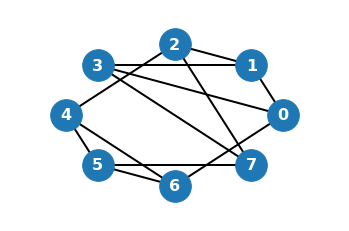

In [20]:
V = [0,1,2,3,4,5,6,7]
# V = [0,1,2,3,4,5,6,7,8,9]
# V = [0,1,2,3,4,5,6,7,8,9,10,11]

V.sort()
print(V)

E = E0[4]

n = len(V)


target_graph = nx.Graph()
target_graph.add_nodes_from(V)
target_graph.add_edges_from(E)

target_graph = nx.Graph()
target_graph.add_nodes_from(V)
target_graph.add_edges_from(E)
pos = nx.circular_layout(target_graph)
options = {
    "with_labels": True,
    "font_size": 16,
    "font_weight": "bold",
    "font_color": "white",
    "node_size": 1000,
    "width": 2
}
nx.draw_networkx(target_graph, pos, **options)
ax = plt.gca()
ax.margins(0.20)
plt.axis("off")
plt.show()

# Get the neighbors' information for building the circuit
info = get_info_neighbors(target_graph)

In [21]:
ham = build_ham(target_graph)
k = 3 # the degree of the regular graphs
counts = 1  # The number of repeated RI processes when the number of ansatz layers is 1
delta = 0.1  # If the difference in the change of the expectation function value between consecutive optimizations is smaller than the given threshold delta, the current run terminates
iterations = []  # Store the number of iterations consumed in each round of optimization in one run
mixers = []  # Store the vertex indices where mixers are allowed to be applied in each run
values = []  # Store the changes in the expectation function value in one run
running_time = []  # Store the simulation time consumed in each run
depth = []  # Store the circuit depth for each run

times = 100*n  # The number of times the adaptive ansatz is repeated

    
# Randomly initialize, and keep the optimal parameters corresponding to the best expectation value
total_SEED = [] 
for i in range(0, times):
    total_SEED.append(random.randint(1, 25000))
my_logger.info('Random seeds total_SEED = {}'.format(total_SEED))

for i in range(0, len(total_SEED)):
    start_time = time.time()  # The start time of the optimization run
    SEED = total_SEED[i]
    function_values, mixer_nodes, ITR, circuit_depth_layer = adaptive_ansatz(SEED)  # The returned values are the expectation function values at the end of each optimization round, the vertex indices where mixers are allowed, and the iterations consumed in each round
    iterations.append(ITR)
    mixers.append(mixer_nodes)
    values.append(function_values)
    depth.append(circuit_depth_layer)

    end_time = time.time()  # End time
    delta0 = end_time - start_time
    running_time.append(delta0)

Random seeds total_SEED = [19904, 18864]
The vertices where the mixer can be applied in the first layer: [7, 0, 3, 4, 5]



The 1-th global random initialization
SEED = 781, initial_beta = [0.54655486], initial_gamma = [0.7025923]
This is the function named execute_function, params = [gamma1, beta1, beta2, ...] = [0.7025923, 0.54655486]
weight = [0.7025923  0.54655486]
lr = 0.05, ITR = 600
train_step = 50, loss = -2.9405200481414795
Convergence condition met, iterations = 63, loss changes = [-0.34374985, -0.4032647, -0.4659761, -0.5315037, -0.59946066, -0.66945493, -0.74109304, -0.8139845, -0.88774633, -0.96200824, -1.0364186, -1.1106489, -1.1843994, -1.2574033, -1.3294284, -1.4002815, -1.4698068, -1.5378865, -1.6044389, -1.6694151, -1.7327954, -1.794584, -1.8548052, -1.9134972, -1.9707075, -2.0264878, -2.0808895, -2.1339598, -2.185739, -2.2362564, -2.2855291, -2.3335607, -2.3803399, -2.4258409, -2.4700224, -2.512831, -2.5542, -2.5940533, -2.6323075, -2.6688747, -2.703666, -2.7365947, 

In [22]:
my_logger.info('depth = {}'.format(depth))

# Record the final circuit depth in each run
max_depth = []
for i in range(0,len(depth)):
    max_depth.append(max(depth[i]))
my_logger.info('max_depth = {}'.format(max_depth))

depth = [[16, 19, 22], [16, 19, 22]]
max_depth = [22, 22]


In [26]:
my_logger.info('values = {}'.format(values))
my_logger.info('\n')
my_logger.info('mixers = {}'.format(mixers))
my_logger.info('\n')
my_logger.info('iterations = {}'.format(iterations))
my_logger.info('\n')

my_logger.info('classical_running_time = {}'.format(running_time))
my_logger.info('\n')

values = [[2.99998, 2.99979, 2.99993], [2.99907, 2.99947, 2.99976]]


mixers = [[[7, 0, 3, 4, 5], [1], [1]], [[2, 4, 6, 5, 3], [0], [7]]]


iterations = [[63.0, 3, 3, 3], [4.0, 3, 3, 3]]


classical_running_time = [15.389078140258789, 13.294432878494263]




In [24]:
max_loss_run = [] # Store the expectation function value in each run
for i in range(0,len(values)):
    max_loss_run.append(max(values[i]))
my_logger.info('max_loss_run = {}'.format(max_loss_run))

total_iter_run = [] # Store the consumption of iterations in each run
for i in range(0,len(iterations)):
    s = 0
    for j in range(0,len(iterations[i])):
        s = s+iterations[i][j]
    total_iter_run.append(s)
my_logger.info('\n')
my_logger.info('total_iter_run = {}'.format(total_iter_run))

max_loss_run = [2.99998, 2.99976]


total_iter_run = [72.0, 13.0]


In [25]:
# Calculate the degree of the vertices where mixers are allowed to be applied in each run, used for the subsequent calculation of CNOT gate numbers corresponding to multi-qubit controlled gates
degrees = []  # Store the degree information of the vertices where mixers are allowed to be applied in multiple runs

# For the i-th run
for i in range(0, len(mixers)):
    degrees_run = []  # Store the degree of the vertices where mixers are allowed to be applied at each layer during this run

    for j in range(0, len(mixers[i])):
        degrees_round = []  # The degree of the vertices where mixers are allowed to be applied at layer j
        
        # Visit the vertices where mixers are allowed to be applied at layer j and store their degrees
        for t in range(0, len(mixers[i][j])):
            node = mixers[i][j][t]  # The vertex where a mixer is allowed to be applied
            d = len(info[node])  # The degree of the vertex
            degrees_round.append(d)
        degrees_run.append(degrees_round)  # The degree of the vertices allowed to apply the mixer at layer j during this run (multiple vertices, multiple degrees)
    degrees.append(degrees_run)  # Store the result for this run
    
my_logger.info('degrees = {}'.format(degrees))

degrees = [[[3, 3, 3, 3, 3], [3], [3]], [[3, 3, 3, 3, 3], [3], [3]]]
